In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import os

In [2]:
state0 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/State700/Hs_010.nc')
#state0 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/sill30/state_002.nc')
state = state0.isel(Y = range(1,10)) # Remove the boundary walls in y direction

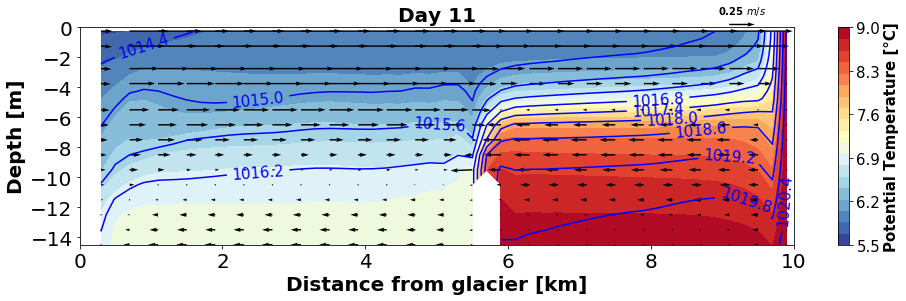

In [8]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Sill010/AboveHs_Qf0700/"
#fig_path = "/home/1959/Jupyter_Figs/sill30/Along_fjord_animation_Qf0200/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
x = state.X.data / 1000 # x coornidate in km
z = state.Z.data
pres = gsw.p_from_z(z, 0)
ct = np.linspace(5.5,9,20) # Contour range for temperature
count = 0

# Time range
for t in range(22,23):
    count += 1
    pt = state.Temp.isel(T = t).data
    s = state.S.isel(T = t).data
    # Convert the location of data U from cell corner to center
    u = (state.U.isel(T = t, Xp1 = range(50)).data + state.U.isel(T = t, Xp1 = range(1,51)).data) /2
    w = state.W.isel(T = t).data

    mask = (pt == 0)
    pt[mask] = np.nan
    s[mask] = np.nan
    u[mask] = np.nan
    w[mask] = np.nan
    pt_ymean = pt.mean(1)
    s_ymean = s.mean(1)
    rho_ymean = gsw.rho(s_ymean, pt_ymean, pres)
    u_ymean = u.mean(1)
    w_ymean = w.mean(1)
    

    fig, ax = plt.subplots(figsize=(16,4))  
    # Plot potential temperature field
    plt.contourf(x,z[:20],pt_ymean[:20,:], ct, cmap = 'RdYlBu_r')
    cbar = plt.colorbar(ticks = np.linspace(5.5,9,6))
    cbar.ax.tick_params(labelsize = 15)
    cbar.set_label('Potential Temperature [\N{DEGREE SIGN}C]', size = 15, weight = 'bold')
    
    # Plot isopycnals
    CS = plt.contour(x,z[:20],rho_ymean[:20,:],10, colors = 'b')
    plt.clabel(CS, fmt='%1.1f', fontsize=15, inline=1)

    # Plot velocity(Z, X) field
    u_ymean[[1,3,4,6,8,9], :] = np.nan
    w_ymean[[1,3,4,6,8,9], :] = np.nan
    u_ymean[:,::2] = np.nan
    w_ymean[:,::2] = np.nan
    Q = ax.quiver(x,z[:20],u_ymean[:20,:], w_ymean[:20,:], width=0.002, scale=7)
    ax.quiverkey(Q, 0.7, 0.89, 0.25,r'0.25 $m/s$', fontproperties={'weight': 'bold', 'size' : 10}, coordinates='figure')

    ax.set_xlim([0,10])
    #ax.set_xticklabels(np.linspace(0,10,6, dtype = int), size = 20)
    ax.set_ylim([z[19],0])
    #ax.set_yticklabels(np.linspace(-150,0,11, dtype = int), size = 20)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    ax.set_xlabel('Distance from glacier [km]', size = 20, weight = 'bold')
    ax.set_ylabel('Depth [m]', size = 20, weight = 'bold')
    plt.title('Day ' + str(int(t/2)), size = 20, weight = 'bold')
    #plt.close()
    #fig.savefig(fig_path + '/time' + format(count, '03d') + '.png', dpi = 150, bbox_inches='tight')

In [4]:
# Generate GIF from saved output figures
import imageio
import glob

images = []
imagenames = sorted(glob.glob(fig_path + '/time*.png'))

for filename in imagenames:
    images.append(imageio.imread(filename))
imageio.mimsave(fig_path + '/30Day.gif', images, duration=.6)